In [61]:
import pandas as pd
from sklearn.cluster import AgglomerativeClustering
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt

CSV_PATH = '../datos/Food_Delivery_Times.csv'
df = pd.read_csv(CSV_PATH)

feature_cols = ['Distance_km','Preparation_Time_min','Courier_Experience_yrs']
X = df[feature_cols]

imp = SimpleImputer(strategy="median")
X = pd.DataFrame(imp.fit_transform(X), columns=X.columns, index=X.index)

y = pd.cut(
    df['Delivery_Time_min'].fillna(df['Delivery_Time_min'].median()),
    bins=[-float('inf'), 25, 40, float('inf')], labels=[0,1,2]
).astype(int)


In [ ]:

agnes = AgglomerativeClustering(n_clusters=3, linkage='ward')

print('Grupos AGNES (conteo por cluster):', pd.Series(cluster_labels).value_counts().sort_index().to_dict())


Grupos AGNES (conteo por cluster): {0: 491, 1: 360, 2: 149}


In [63]:

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=42)
X_train, X_val,  y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42)
print('Shapes -> train:', X_train.shape, '| val:', X_val.shape, '| test:', X_test.shape)


Shapes -> train: (600, 3) | val: (200, 3) | test: (200, 3)


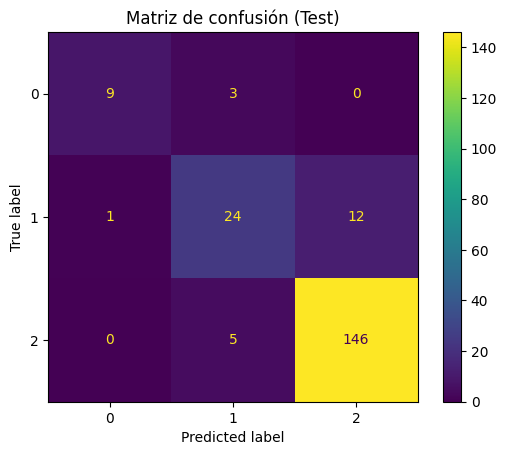

Reporte (TEST):
               precision    recall  f1-score   support

           0       0.90      0.75      0.82        12
           1       0.75      0.65      0.70        37
           2       0.92      0.97      0.94       151

    accuracy                           0.90       200
   macro avg       0.86      0.79      0.82       200
weighted avg       0.89      0.90      0.89       200



In [64]:

clf = RandomForestClassifier(n_estimators=300, random_state=42)
clf.fit(X_train, y_train)

y_test_pred = clf.predict(X_test)
cm = confusion_matrix(y_test, y_test_pred, labels=[0,1,2])

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1,2])
disp.plot()
plt.title('Matriz de confusión (Test)')
plt.show()

print('Reporte (TEST):\n', classification_report(y_test, y_test_pred))
